<img src="images/seattle.jpg">

# King County House Sales Analysis
Author: Jennifer Ha
***

## Overview 
This project analyzes house sales data in King County in Seattle from 2014-2015, which consists of ~21,600 transactions. Through some exploratory data analyses and iterative regression models, we will identify some features that have the strongest relationship with price.. The result shows that the model with feature engineering was the best-performing model, also revealing that waterfront properties, more viewings to potential buyers, and higher grading using King County grading system have the biggest impact on house prices.

## Business Problem
Star Real Estate Agency (imaginary real estate company in Seattle) is seeking advice to close deals with higher housing sales prices. In this project, we are providing analysis on what type of properties they should prioritize to acquire for their listing as well as how to attract buyers. We are creating a model to estimate the price of a home when those criterias are met. Questions to consider:
* Is a waterfront property worth more than an inland property?
* Does the number of viewings to potential buyers affect the housing price?
* Does the King County grading system affect the housing price?

## Data
The dataset consists of ~21,600 rows of real estate transactions from King County, Seattle (WA) from 2014-2015. The columns represent different features associated with each property, which are outlined below. The target variable is the price of the property, which will be used in our models to determine the winning model, along with features that have strong relationships with it.

Prior to iterating regression models and predictions, I conducted some exploratory data analyses to clean up the data using IQR method to prepare it for modeling, and went through several iterations to refine the model.

### Columns
* `id`: uniques identifier for a house
* `date`: date the house was sold
* `price`: prediction target
* `bedrooms`: number of bedrooms
* `bathrooms`: number of bathrooms
* `sqft_living`: square foot living space
* `sqft_lot`: square foot of lot
* `floors`: number of floors
* `waterfront`: house which has a view to a waterfront
* `view`: number of viewings
* `condition`: how good the condition is (overall)
* `grade`: overall grade given to the housing unit, based on King County grading system
* `sqft_above`: square footage of house apart from basement
* `sqft_basement`: square footage of the basement
* `yr_built`: Built Year
* `yr_renovated`: Year when house was renovated
* `zipcode`: zip
* `lat`: Latitude coordinate
* `long`: Longitude coordinate
* `sqft_living15`: The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors

***

### Data Preparation & Clean Up

In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.colors as pltcol
import seaborn as sns
#import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
#import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OneHotEncoder
#
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox
#
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

# Import my personal functions 
from functions import model_summary,linear_model

# Remove scientific notation
pd.options.display.float_format = '{:,.5f}'.format

# Display all the columns without truncation
pd.set_option('display.max_columns', None)

# Import data into a dataframe and preview 
df = pd.read_csv('data/kc_house_data.csv')
df.head()

id        date         price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014 221,900.00000         3    1.00000         1180   
1  6414100192   12/9/2014 538,000.00000         3    2.25000         2570   
2  5631500400   2/25/2015 180,000.00000         2    1.00000          770   
3  2487200875   12/9/2014 604,000.00000         4    3.00000         1960   
4  1954400510   2/18/2015 510,000.00000         3    2.00000         1680   

   sqft_lot  floors  waterfront    view  condition  grade  sqft_above  \
0      5650 1.00000         nan 0.00000          3      7        1180   
1      7242 2.00000     0.00000 0.00000          3      7        2170   
2     10000 1.00000     0.00000 0.00000          3      6         770   
3      5000 1.00000     0.00000 0.00000          5      7        1050   
4      8080 1.00000     0.00000 0.00000          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat       long  \
0           0.0      1955       0.00000    98178 47.51120 -122.25700   
1         400.0      1951   1,991.00000    98125 47.72100 -122.31900   
2           0.0      1933           nan    98028 47.73790 -122.23300   
3         910.0      1965       0.00000    98136 47.52080 -122.39300   
4           0.0      1987       0.00000    98074 47.61680 -122.04500   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [2]:
# Get summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Check for Duplicates
We want the `id` column to work an index to represent each transaction rather than each property. Let's take a look at the duplicates for houses that were sold more than once.

In [3]:
# Check for duplicates in 'id' which should work as index
df.id.duplicated().sum()

177

In [4]:
# Create a separate table to examine the duplicates
df_id_duplicates = df[df.duplicated('id')]

df_id_duplicates

id        date           price  bedrooms  bathrooms  \
94     6021501535  12/23/2014   700,000.00000         3    1.50000   
314    4139480200   12/9/2014 1,400,000.00000         4    3.25000   
325    7520000520   3/11/2015   240,500.00000         2    1.00000   
346    3969300030  12/29/2014   239,900.00000         4    1.00000   
372    2231500030   3/24/2015   530,000.00000         4    2.25000   
...           ...         ...             ...       ...        ...   
20165  7853400250   2/19/2015   645,000.00000         4    3.50000   
20597  2724049222   12/1/2014   220,000.00000         2    2.50000   
20654  8564860270   3/30/2015   502,000.00000         4    2.50000   
20764  6300000226    5/4/2015   380,000.00000         4    1.00000   
21565  7853420110    5/4/2015   625,000.00000         3    3.00000   

       sqft_living  sqft_lot  floors  waterfront    view  condition  grade  \
94            1580      5000 1.00000     0.00000 0.00000          3      8   
314           4290     12103 1.00000     0.00000 3.00000          3     11   
325           1240     12092 1.00000     0.00000 0.00000          3      6   
346           1000      7134 1.00000     0.00000 0.00000          3      6   
372           2180     10754 1.00000     0.00000 0.00000          5      7   
...            ...       ...     ...         ...     ...        ...    ...   
20165         2910      5260 2.00000     0.00000 0.00000          3      9   
20597         1000      1092 2.00000     0.00000 0.00000          3      7   
20654         2680      5539 2.00000         nan 0.00000          3      8   
20764         1200      2171 1.50000     0.00000 0.00000          3      7   
21565         2780      6000 2.00000     0.00000 0.00000          3      9   

       sqft_above sqft_basement  yr_built  yr_renovated  zipcode      lat  \
94           1290         290.0      1939       0.00000    98117 47.68700   
314          2690        1600.0      1997       0.00000    98006 47.55030   
325           960         280.0      1922   1,984.00000    98146 47.49570   
346          1000           0.0      1943           nan    98178 47.48970   
372          1100        1080.0      1954       0.00000    98133 47.77110   
...           ...           ...       ...           ...      ...      ...   
20165        2910           0.0      2012       0.00000    98065 47.51680   
20597         990          10.0      2004       0.00000    98118 47.54190   
20654        2680           0.0      2013       0.00000    98045 47.47590   
20764        1200           0.0      1933       0.00000    98133 47.70760   
21565        2780           0.0      2013           nan    98065 47.51840   

            long  sqft_living15  sqft_lot15  
94    -122.38600           1570        4500  
314   -122.10200           3860       11244  
325   -122.35200           1820        7460  
346   -122.24000           1020        7138  
372   -122.34100           1810        6929  
...          ...            ...         ...  
20165 -121.88300           2910        5260  
20597 -122.27100           1330        1466  
20654 -121.73400           2680        5992  
20764 -122.34200           1130        1598  
21565 -121.88600           2850        6000  

[177 rows x 21 columns]

In [5]:
# Spot check data
df.loc[df['id'] == 6021501535]

id        date         price  bedrooms  bathrooms  sqft_living  \
93  6021501535   7/25/2014 430,000.00000         3    1.50000         1580   
94  6021501535  12/23/2014 700,000.00000         3    1.50000         1580   

    sqft_lot  floors  waterfront    view  condition  grade  sqft_above  \
93      5000 1.00000     0.00000 0.00000          3      8        1290   
94      5000 1.00000     0.00000 0.00000          3      8        1290   

   sqft_basement  yr_built  yr_renovated  zipcode      lat       long  \
93         290.0      1939       0.00000    98117 47.68700 -122.38600   
94         290.0      1939       0.00000    98117 47.68700 -122.38600   

    sqft_living15  sqft_lot15  
93           1570        4500  
94           1570        4500

In [6]:
# Spot check data
df.loc[df['id'] == 3969300030]

id        date         price  bedrooms  bathrooms  sqft_living  \
345  3969300030   7/23/2014 165,000.00000         4    1.00000         1000   
346  3969300030  12/29/2014 239,900.00000         4    1.00000         1000   

     sqft_lot  floors  waterfront    view  condition  grade  sqft_above  \
345      7134 1.00000     0.00000 0.00000          3      6        1000   
346      7134 1.00000     0.00000 0.00000          3      6        1000   

    sqft_basement  yr_built  yr_renovated  zipcode      lat       long  \
345           0.0      1943       0.00000    98178 47.48970 -122.24000   
346           0.0      1943           nan    98178 47.48970 -122.24000   

     sqft_living15  sqft_lot15  
345           1020        7138  
346           1020        7138

In [7]:
# Spot check data
df.loc[df['id'] == 6300000226]

id       date         price  bedrooms  bathrooms  sqft_living  \
20763  6300000226  6/26/2014 240,000.00000         4    1.00000         1200   
20764  6300000226   5/4/2015 380,000.00000         4    1.00000         1200   

       sqft_lot  floors  waterfront    view  condition  grade  sqft_above  \
20763      2171 1.50000     0.00000 0.00000          3      7        1200   
20764      2171 1.50000     0.00000 0.00000          3      7        1200   

      sqft_basement  yr_built  yr_renovated  zipcode      lat       long  \
20763           0.0      1933       0.00000    98133 47.70760 -122.34200   
20764           0.0      1933       0.00000    98133 47.70760 -122.34200   

       sqft_living15  sqft_lot15  
20763           1130        1598  
20764           1130        1598

I'm going to keep the latest transaction only since we are not interested in historical transaction data.

In [8]:
# Drop the historical data
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [9]:
# Check if the duplicates are removed
df.id.duplicated().sum()

0

### Remove `Date`
Let's convert the `date` column from object to datetime. Then, prepare a `month` column for Exploratory Data Analysis (EDA) later in this Jupyter Notebook. 

In [10]:
# Convert date
df['date'] = pd.to_datetime(df['date'])

# Create 'Month' column
df['month_sold'] = df.date.dt.month

Drop the origianl `date` column as it won't be needed for this project.

In [11]:
df.drop(['date'], axis= 1, inplace= True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     19067 non-null  float64
 8   view           21357 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  object 
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   17607 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

### Integer - sqft_basement
The `sqft_basement` column is an object where as the values are showing up as float. Let's take a look at this column.

In [13]:
# Check why sqft_basement is an object and not an integer
df.sqft_basement.value_counts()

0.0       12716
?           452
600.0       216
500.0       206
700.0       206
          ...  
2360.0        1
374.0         1
266.0         1
2050.0        1
1024.0        1
Name: sqft_basement, Length: 304, dtype: int64

The `sqft_basement` column contains '?' which appears to be missing values. Let's replace them with '0' as we are unable to track down this information.

In [14]:
# Replace '?' in sqft_basement to 0 since they are unidentifiable
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

df.sqft_basement.value_counts()

0.0       13168
600.0       216
500.0       206
700.0       206
800.0       201
          ...  
2130.0        1
516.0         1
875.0         1
1852.0        1
508.0         1
Name: sqft_basement, Length: 303, dtype: int64

Now that all values are numerical, let's change the data type to 'float'.

In [15]:
# Change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float')

For this project, we are interested in whether a property has a basement rather than how big the basement is. Therefore, let's replace the basement size for each property with '1' to indicate that the property has a basement.

In [16]:
# Replace values with 1 to indicate that the property has a basement
df.loc[df['sqft_basement'] > 0, 'sqft_basement'] = 1

In [17]:
# Rename the column to 'basement_yn'
df = df.rename(columns={"sqft_basement":"basement_yn"})

In [18]:
# Check the DataFrame
df

id         price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520 221,900.00000         3    1.00000         1180      5650   
1      6414100192 538,000.00000         3    2.25000         2570      7242   
2      5631500400 180,000.00000         2    1.00000          770     10000   
3      2487200875 604,000.00000         4    3.00000         1960      5000   
4      1954400510 510,000.00000         3    2.00000         1680      8080   
...           ...           ...       ...        ...          ...       ...   
21592   263000018 360,000.00000         3    2.50000         1530      1131   
21593  6600060120 400,000.00000         4    2.50000         2310      5813   
21594  1523300141 402,101.00000         2    0.75000         1020      1350   
21595   291310100 400,000.00000         3    2.50000         1600      2388   
21596  1523300157 325,000.00000         2    0.75000         1020      1076   

       floors  waterfront    view  condition  grade  sqft_above  basement_yn  \
0     1.00000         nan 0.00000          3      7        1180      0.00000   
1     2.00000     0.00000 0.00000          3      7        2170      1.00000   
2     1.00000     0.00000 0.00000          3      6         770      0.00000   
3     1.00000     0.00000 0.00000          5      7        1050      1.00000   
4     1.00000     0.00000 0.00000          3      8        1680      0.00000   
...       ...         ...     ...        ...    ...         ...          ...   
21592 3.00000     0.00000 0.00000          3      8        1530      0.00000   
21593 2.00000     0.00000 0.00000          3      8        2310      0.00000   
21594 2.00000     0.00000 0.00000          3      7        1020      0.00000   
21595 2.00000         nan 0.00000          3      8        1600      0.00000   
21596 2.00000     0.00000 0.00000          3      7        1020      0.00000   

       yr_built  yr_renovated  zipcode      lat       long  sqft_living15  \
0          1955       0.00000    98178 47.51120 -122.25700           1340   
1          1951   1,991.00000    98125 47.72100 -122.31900           1690   
2          1933           nan    98028 47.73790 -122.23300           2720   
3          1965       0.00000    98136 47.52080 -122.39300           1360   
4          1987       0.00000    98074 47.61680 -122.04500           1800   
...         ...           ...      ...      ...        ...            ...   
21592      2009       0.00000    98103 47.69930 -122.34600           1530   
21593      2014       0.00000    98146 47.51070 -122.36200           1830   
21594      2009       0.00000    98144 47.59440 -122.29900           1020   
21595      2004       0.00000    98027 47.53450 -122.06900           1410   
21596      2008       0.00000    98144 47.59410 -122.29900           1020   

       sqft_lot15  month_sold  
0            5650          10  
1            7639          12  
2            8062           2  
3            5000          12  
4            7503           2  
...           ...         ...  
21592        1509           5  
21593        7200           2  
21594        2007           6  
21595        1287           1  
21596        1357          10  

[21420 rows x 21 columns]

### Null Values
We have identified that `waterfront`, `view`, and `yr_renovated` columns have some missing values. Let's examine each of them and determine how we will proceed.

In [19]:
# Check 'waterfront'
df.waterfront.value_counts(normalize = False)

0.00000    18921
1.00000      146
Name: waterfront, dtype: int64

In [20]:
# Check 'view'
df.view.value_counts(normalize = True)

0.00000   0.90148
2.00000   0.04476
3.00000   0.02365
1.00000   0.01540
4.00000   0.01470
Name: view, dtype: float64

In [21]:
# Check 'yr_renovated'
df.yr_renovated.value_counts(normalize = True)

0.00000       0.95797
2,014.00000   0.00415
2,003.00000   0.00176
2,013.00000   0.00176
2,007.00000   0.00170
                ...  
1,934.00000   0.00006
1,971.00000   0.00006
1,954.00000   0.00006
1,950.00000   0.00006
1,944.00000   0.00006
Name: yr_renovated, Length: 70, dtype: float64

Above analysis shows that:
1. 99.2% of properties in the dataseet are not near the Seattle waterfront.
2. 90.1% of properties do not have a view. 
3. 95.8% of properties have not been renovated since it was built.

While having such large amount of null values can be problematic, it makes sense in this scenario.Therefore, we will simply replace those null values with zeros. 

In [22]:
# Replace null values with zeros
df.fillna(0, inplace= True)

Lastly, let's re-set the index.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     21420 non-null  float64
 8   view           21420 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  basement_yn    21420 non-null  float64
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   21420 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

For this exercise, we will focus on whether the property has been renovated rather than when it was renovated. Therefore, Let's replace the values with '1' if renovated, and keep '0' if not renovated.

In [24]:
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

In [25]:
df = df.rename(columns={"yr_renovated":"renovated_yn"})

In [26]:
# Drop 'id' as we no longer need this column
df.drop(['id'], axis= 1, inplace= True)

### Outliers

let's visualize and check the distributions in each column and we will use IQR method to remove outliers.


In [27]:
df.describe()

price     bedrooms    bathrooms  sqft_living        sqft_lot  \
count    21,420.00000 21,420.00000 21,420.00000 21,420.00000    21,420.00000   
mean    541,861.42815      3.37395      2.11843  2,083.13263    15,128.03800   
std     367,556.93785      0.92540      0.76872    918.80841    41,530.79684   
min      78,000.00000      1.00000      0.50000    370.00000       520.00000   
25%     324,950.00000      3.00000      1.75000  1,430.00000     5,040.00000   
50%     450,550.00000      3.00000      2.25000  1,920.00000     7,614.00000   
75%     645,000.00000      4.00000      2.50000  2,550.00000    10,690.50000   
max   7,700,000.00000     33.00000      8.00000 13,540.00000 1,651,359.00000   

            floors   waterfront         view    condition        grade  \
count 21,420.00000 21,420.00000 21,420.00000 21,420.00000 21,420.00000   
mean       1.49599      0.00682      0.23399      3.41078      7.66279   
std        0.54008      0.08228      0.76544      0.65004      1.17197   
min        1.00000      0.00000      0.00000      1.00000      3.00000   
25%        1.00000      0.00000      0.00000      3.00000      7.00000   
50%        1.50000      0.00000      0.00000      3.00000      7.00000   
75%        2.00000      0.00000      0.00000      4.00000      8.00000   
max        3.50000      1.00000      4.00000      5.00000     13.00000   

        sqft_above  basement_yn     yr_built  renovated_yn      zipcode  \
count 21,420.00000 21,420.00000 21,420.00000  21,420.00000 21,420.00000   
mean   1,791.17021      0.38525  1,971.09300       0.03455 98,077.87437   
std      828.69296      0.48667     29.38714       0.18263     53.47748   
min      370.00000      0.00000  1,900.00000       0.00000 98,001.00000   
25%    1,200.00000      0.00000  1,952.00000       0.00000 98,033.00000   
50%    1,560.00000      0.00000  1,975.00000       0.00000 98,065.00000   
75%    2,220.00000      1.00000  1,997.00000       0.00000 98,117.00000   
max    9,410.00000      1.00000  2,015.00000       1.00000 98,199.00000   

               lat         long  sqft_living15    sqft_lot15   month_sold  
count 21,420.00000 21,420.00000   21,420.00000  21,420.00000 21,420.00000  
mean      47.56020   -122.21378    1,988.38408  12,775.71816      6.56401  
std        0.13859      0.14079      685.53706  27,345.62187      3.11785  
min       47.15590   -122.51900      399.00000     651.00000      1.00000  
25%       47.47120   -122.32800    1,490.00000   5,100.00000      4.00000  
50%       47.57210   -122.23000    1,840.00000   7,620.00000      6.00000  
75%       47.67810   -122.12500    2,370.00000  10,086.25000      9.00000  
max       47.77760   -121.31500    6,210.00000 871,200.00000     12.00000

In [28]:
col = df.columns
col

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement_yn',
       'yr_built', 'renovated_yn', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'month_sold'],
      dtype='object')

In [29]:
def plot_boxplots(df, col=None, boxplot=True):
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=3, ncols=2)

    ax1 = fig.add_subplot(gs[1, 0])
    if col is None:
        data = df.copy()
        name = data.name
    else:
        data = df[col].copy()
        name = col

    ## Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(f'Box Plot of {name.title()}')

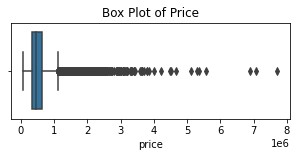

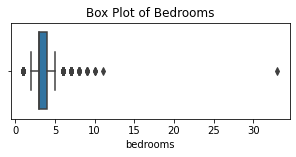

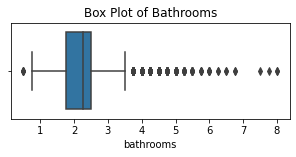

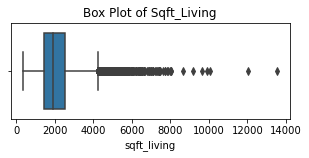

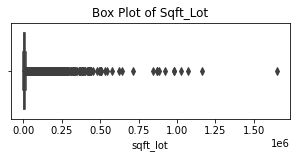

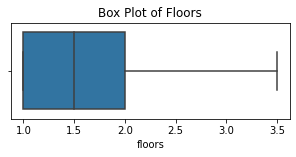

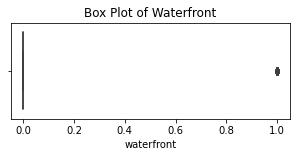

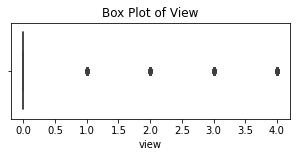

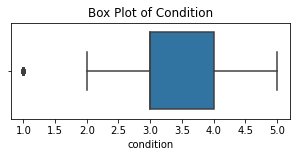

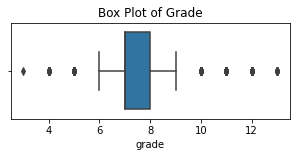

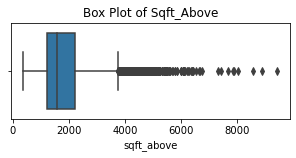

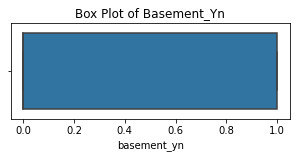

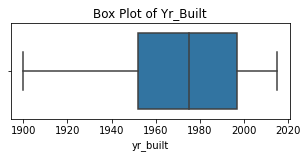

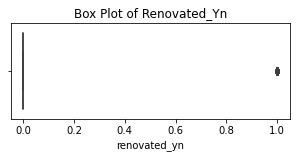

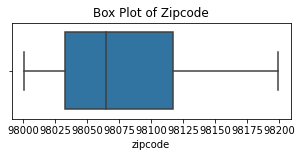

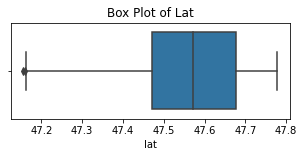

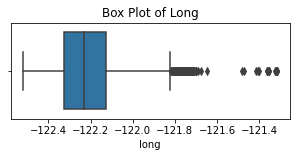

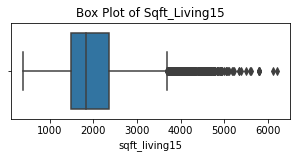

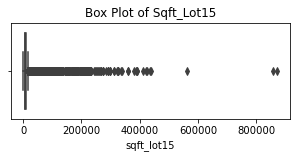

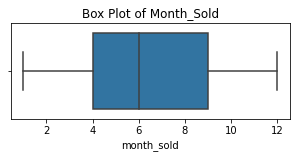

In [30]:
for col in df:
    plot_boxplots(df =df , col=col)

In [31]:
# Remove outliers using IQR method
# Code modified from https://stackoverflow.com/questions/50461349/how-to-remove-outlier-from-dataframe-using-iqr

def outlier_IQR(df):
    
    keep = df.describe()
    q1 = keep['25%']
    q3 = keep['75%']
    IQR = q3-q1
    outliers =(df < (q1- 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))
    return outliers

In [32]:
# Create list of columns to remove outliers from
outliers_col = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_living15', 'sqft_lot15']
df1 = df.copy()

# Remove outliers for specified columns
for col in outliers_col:
    df1 = df1[~outlier_IQR(df1[col])]

In [33]:
df1

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     221,900.00000         3    1.00000         1180      5650 1.00000   
1     538,000.00000         3    2.25000         2570      7242 2.00000   
2     180,000.00000         2    1.00000          770     10000 1.00000   
3     604,000.00000         4    3.00000         1960      5000 1.00000   
4     510,000.00000         3    2.00000         1680      8080 1.00000   
...             ...       ...        ...          ...       ...     ...   
21592 360,000.00000         3    2.50000         1530      1131 3.00000   
21593 400,000.00000         4    2.50000         2310      5813 2.00000   
21594 402,101.00000         2    0.75000         1020      1350 2.00000   
21595 400,000.00000         3    2.50000         1600      2388 2.00000   
21596 325,000.00000         2    0.75000         1020      1076 2.00000   

       waterfront    view  condition  grade  sqft_above  basement_yn  \
0         0.00000 0.00000          3      7        1180      0.00000   
1         0.00000 0.00000          3      7        2170      1.00000   
2         0.00000 0.00000          3      6         770      0.00000   
3         0.00000 0.00000          5      7        1050      1.00000   
4         0.00000 0.00000          3      8        1680      0.00000   
...           ...     ...        ...    ...         ...          ...   
21592     0.00000 0.00000          3      8        1530      0.00000   
21593     0.00000 0.00000          3      8        2310      0.00000   
21594     0.00000 0.00000          3      7        1020      0.00000   
21595     0.00000 0.00000          3      8        1600      0.00000   
21596     0.00000 0.00000          3      7        1020      0.00000   

       yr_built  renovated_yn  zipcode      lat       long  sqft_living15  \
0          1955       0.00000    98178 47.51120 -122.25700           1340   
1          1951       1.00000    98125 47.72100 -122.31900           1690   
2          1933       0.00000    98028 47.73790 -122.23300           2720   
3          1965       0.00000    98136 47.52080 -122.39300           1360   
4          1987       0.00000    98074 47.61680 -122.04500           1800   
...         ...           ...      ...      ...        ...            ...   
21592      2009       0.00000    98103 47.69930 -122.34600           1530   
21593      2014       0.00000    98146 47.51070 -122.36200           1830   
21594      2009       0.00000    98144 47.59440 -122.29900           1020   
21595      2004       0.00000    98027 47.53450 -122.06900           1410   
21596      2008       0.00000    98144 47.59410 -122.29900           1020   

       sqft_lot15  month_sold  
0            5650          10  
1            7639          12  
2            8062           2  
3            5000          12  
4            7503           2  
...           ...         ...  
21592        1509           5  
21593        7200           2  
21594        2007           6  
21595        1287           1  
21596        1357          10  

[16401 rows x 20 columns]

In [34]:
# Drop price to only show correlation between independent variables
corr = df1.drop('price', axis=1).corr().round(2)

In [35]:
# Create mask for upper triangle of matrix
mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

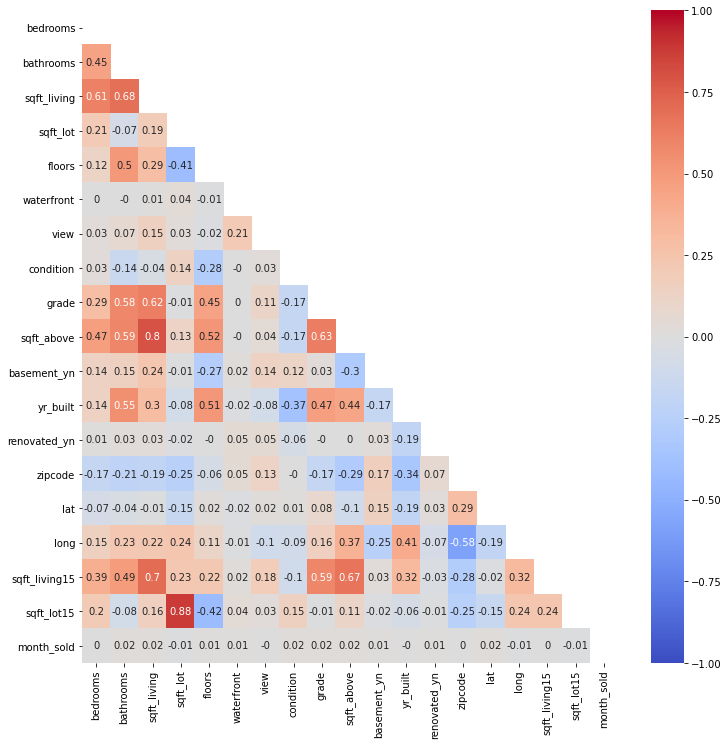

In [36]:
# Create heatmap correlation matrix
# https://medium.com/@chrisshaw982/seaborn-correlation-heatmaps-customized-10246f4f7f4b
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', vmin=-1, vmax=1,mask=mask);

## Exploratory Data Analysis (EDA)
Prior to creating and iterating regression models, we will run some EDA to help the real estate company identify which properties they prioritize to acquire in their listings.

### Question 1: Is a waterfront property worth more than an inland property?

First, let's take a look at how many waterfront properties were bought/sold in 2014-2015.

In [37]:
print(len(df1[df1['waterfront'] == 1]))

15


In [38]:
len(df1[df1['waterfront'] == 1]) / len(df)

0.0007002801120448179

After removing the outliers, there are only 15 waterfront properties remaining in the DataFrame. There were only 146 houses to begin with, which shows that waterfront properties are very rare in the market.

Let's calculate how much more a waterfront property would worth on average.

In [39]:
df1.groupby('waterfront')['price'].mean().round(2)

waterfront
0.00000   452,199.75000
1.00000   796,196.67000
Name: price, dtype: float64

''

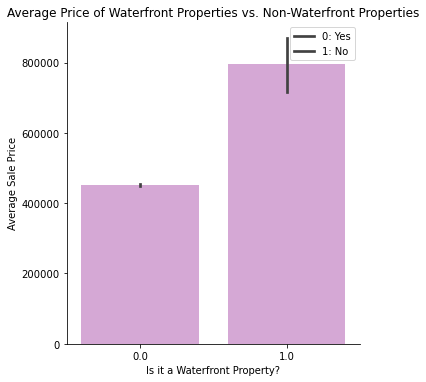

In [40]:
# Create a bar plot to visualize the difference
labels = ['0: Yes', '1: No']
sns.catplot(x="waterfront", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Waterfront Properties vs. Non-Waterfront Properties')
plt.xlabel('Is it a Waterfront Property?')
plt.ylabel('Average Sale Price')
plt.legend(labels= labels)
;

Waterfront properties are definitely in the real estate market but there are not a lot of them out there. I highly recommend securing waterfront properties whenever they are available since those can be worth $344,597 more on average than inland properties.

### Question 2: Does the number of viewings to potential buyers affect the housing price?

In [41]:
df1_v = df1.groupby('view')['price'].mean().round(2)
df1_v

view
0.00000   440,731.37000
1.00000   605,160.79000
2.00000   604,777.25000
3.00000   647,968.04000
4.00000   795,479.17000
Name: price, dtype: float64

Text(0.5, 0, 'View')

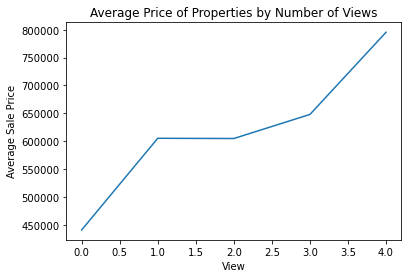

In [42]:
plt.plot(df1_v)
plt.title('Average Price of Properties by Number of Views')
plt.ylabel('Average Sale Price')
plt.xlabel('View')

Text(0.5, 0, 'View')

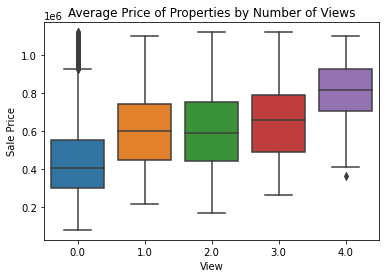

In [43]:
sns.boxplot(x= 'view', y= 'price', data= df1)
plt.title('Average Price of Properties by Number of Views')
plt.ylabel('Sale Price')
plt.xlabel('View')

Overall, the analysis shows that the housing prices increase when more groups of people get the tour. On average, houses with the most number of viewings were sold at a price $354,748 more than houses with 0 views. 

### Question 3: Does the King County grading system affect the housing price? 

In [44]:
df1_g = df1.groupby('grade')['price'].mean().round(2)
df1_g

grade
4    206,300.00000
5    237,756.98000
6    301,922.08000
7    399,963.84000
8    518,085.16000
9    668,319.31000
10   780,199.55000
11   930,000.00000
Name: price, dtype: float64

''

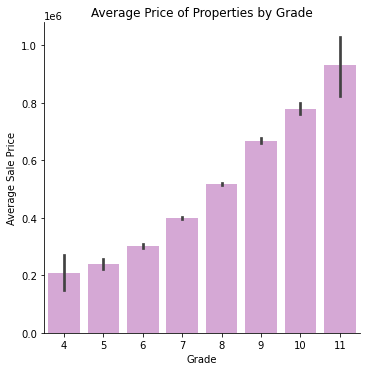

In [45]:
sns.catplot(x="grade", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Properties by Grade')
plt.xlabel('Grade')
plt.ylabel('Average Sale Price')
;

It is very evident that housing prices increase with higher grades. Therefore, we should consider acquiring properties with better grade if possible.

## Model 1

For the first iteration, I wanted to run the model with all the features.

In [46]:
X = df1.drop('price', axis= 1)
y = df1['price']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1810.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        01:10:03   Log-Likelihood:            -2.1343e+05
No. Observations:               16401   AIC:                         4.269e+05
Df Residuals:                   16381   BIC:                         4.271e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.597e+06   1.84e+06      1.955      0.051   -8828.691     7.2e+06
bedrooms      -1.002e+04   1425.532     -7.032      0.000   -1.28e+04   -7230.434
bathrooms      1.634e+04   2209.392      7.397      0.000     1.2e+04    2.07e+04
sqft_living      62.2722      4.522     13.772      0.000      53.409      71.135
sqft_lot         -2.3433      0.562     -4.173      0.000      -3.444      -1.243
floors         1.024e+04   2579.408      3.968      0.000    5179.634    1.53e+04
waterfront     2.461e+05   2.88e+04      8.545      0.000     1.9e+05    3.03e+05
view           3.404e+04   1642.288     20.725      0.000    3.08e+04    3.73e+04
condition       2.78e+04   1459.633     19.048      0.000    2.49e+04    3.07e+04
grade          7.656e+04   1481.644     51.670      0.000    7.37e+04    7.95e+04
sqft_above       34.5297      5.008      6.895      0.000      24.714      44.346
basement_yn    2.553e+04   3307.800      7.719      0.000     1.9e+04     3.2e+04
yr_built      -1935.5366     45.319    -42.709      0.000   -2024.367   -1846.706
renovated_yn   3.471e+04   5336.430      6.505      0.000    2.43e+04    4.52e+04
zipcode        -283.0410     20.658    -13.702      0.000    -323.532    -242.550
lat            5.398e+05   6683.492     80.764      0.000    5.27e+05    5.53e+05
long          -1.546e+04   8840.263     -1.748      0.080   -3.28e+04    1870.737
sqft_living15    46.9997      2.712     17.329      0.000      41.684      52.316
sqft_lot15       -6.4893      0.642    -10.112      0.000      -7.747      -5.231
month_sold    -2477.9465    271.433     -9.129      0.000   -3009.985   -1945.908
==============================================================================
Omnibus:                     1677.157   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3346.384
Skew:                           0.668   Prob(JB):                         0.00
Kurtosis:                       4.764   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa2fac2a850>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'QQ Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

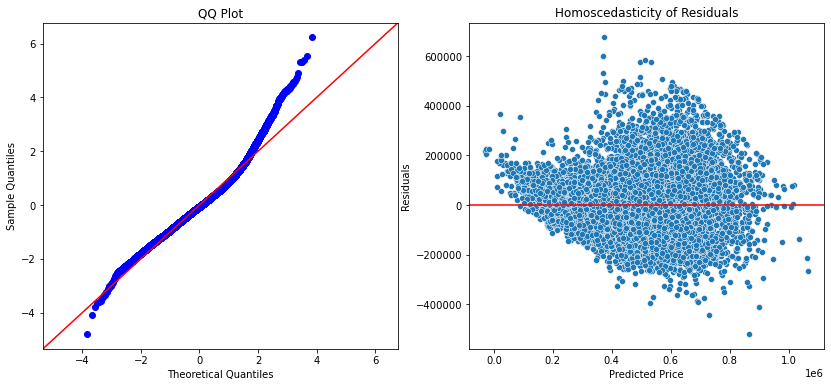

In [47]:
model_summary(df1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 108743.2508875147
Test RMSE: 107671.44744237633
Train R2: 0.6740941146368746
Test R2: 0.6891813829574283


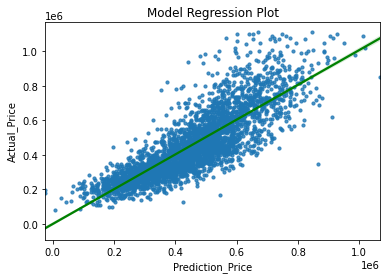

In [49]:
linear_model(X_train,y_train,X_test,y_test)

While our Q-Q plot and homoscedasticity plot are not perfect, they are not too terrible either. Given that this is the first iteration, R squared value at 0.677 is reasonable. We will use this model as a baseline model to evaluate the other models moving forward

## Model 2
For a real estate company, it is not only important to have a strong list of properties but also to understand what would attract the buyers. With that in mind, I selected features that would matter to me when buying a house. Those includes number of bedrooms and bathrooms, size of the property, basement (Y/N), when it was built, renovated (Y/N), and the neighborhood.

In [50]:
df2 = df1.drop(['floors','waterfront','view','grade','lat','long','sqft_living15','sqft_lot15','month_sold'], 
               axis =1)
df2

price  bedrooms  bathrooms  sqft_living  sqft_lot  condition  \
0     221,900.00000         3    1.00000         1180      5650          3   
1     538,000.00000         3    2.25000         2570      7242          3   
2     180,000.00000         2    1.00000          770     10000          3   
3     604,000.00000         4    3.00000         1960      5000          5   
4     510,000.00000         3    2.00000         1680      8080          3   
...             ...       ...        ...          ...       ...        ...   
21592 360,000.00000         3    2.50000         1530      1131          3   
21593 400,000.00000         4    2.50000         2310      5813          3   
21594 402,101.00000         2    0.75000         1020      1350          3   
21595 400,000.00000         3    2.50000         1600      2388          3   
21596 325,000.00000         2    0.75000         1020      1076          3   

       sqft_above  basement_yn  yr_built  renovated_yn  zipcode  
0            1180      0.00000      1955       0.00000    98178  
1            2170      1.00000      1951       1.00000    98125  
2             770      0.00000      1933       0.00000    98028  
3            1050      1.00000      1965       0.00000    98136  
4            1680      0.00000      1987       0.00000    98074  
...           ...          ...       ...           ...      ...  
21592        1530      0.00000      2009       0.00000    98103  
21593        2310      0.00000      2014       0.00000    98146  
21594        1020      0.00000      2009       0.00000    98144  
21595        1600      0.00000      2004       0.00000    98027  
21596        1020      0.00000      2008       0.00000    98144  

[16401 rows x 11 columns]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1134.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        01:10:04   Log-Likelihood:            -2.1840e+05
No. Observations:               16401   AIC:                         4.368e+05
Df Residuals:                   16390   BIC:                         4.369e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -6.026e+06    2.4e+06     -2.507      0.012   -1.07e+07   -1.31e+06
bedrooms     -3.372e+04   1899.396    -17.754      0.000   -3.74e+04      -3e+04
bathrooms     4.067e+04   2883.958     14.100      0.000     3.5e+04    4.63e+04
sqft_living    119.3204      5.907     20.201      0.000     107.743     130.898
sqft_lot        -9.9688      0.400    -24.949      0.000     -10.752      -9.186
condition     1.973e+04   1964.093     10.043      0.000    1.59e+04    2.36e+04
sqft_above      97.1462      6.245     15.557      0.000      84.906     109.386
basement_yn   5.741e+04   4431.336     12.954      0.000    4.87e+04    6.61e+04
yr_built     -1961.9905     56.066    -34.995      0.000   -2071.885   -1852.096
renovated_yn  2.839e+04   7175.674      3.957      0.000    1.43e+04    4.25e+04
zipcode        101.7570     24.163      4.211      0.000      54.396     149.118
==============================================================================
Omnibus:                      844.887   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1044.654
Skew:                           0.531   Prob(JB):                    1.43e-227
Kurtosis:                       3.632   Cond. No.                     2.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa2f990d5e0>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'QQ Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

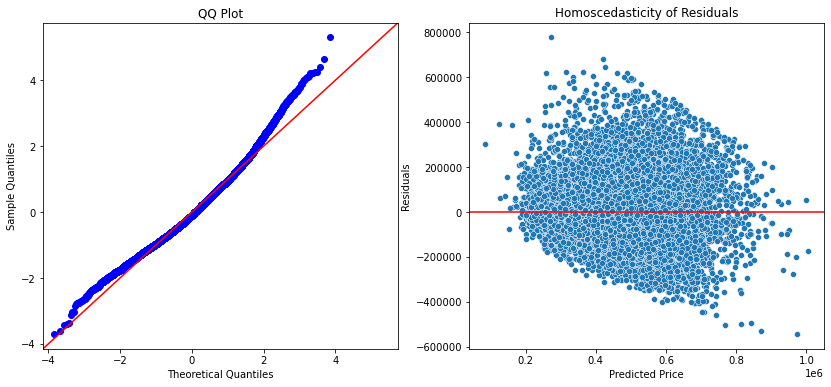

In [51]:
model_summary(df2)

In [52]:
X = df2.drop('price', axis= 1)
y = df2['price']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 146853.64201725935
Test RMSE: 146907.57876606
Train R2: 0.4056298065437628
Test R2: 0.4213788247103898


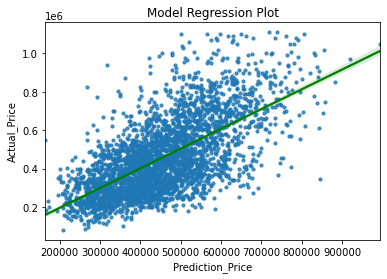

In [54]:
linear_model(X_train,y_train,X_test,y_test)

While Q-Q plot looks slightly better, this model is not so strong compared to the Model 1. Root Mean Squared Error (RMSE) increased and R squared values decreased for both train and test sets. The R squared value for the model also dropped from 0.677 to 0.409. Therefore we will not use this model.

## Model 3

For the next model, let's apply feature engineering on `zipcode` column using One Hot Encoding. There are some other categorical varialbes in our dataset, but we will only focus on `zipcode` column as the other variables are ordinal. 

In [55]:
# One Hot Encode zipcodes column
encoder = OneHotEncoder(drop='first',sparse=False)
encoder.fit(df1[['zipcode']])

ohe_vars = encoder.transform(df1[['zipcode']])

df1_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(['zipcode']),
                      index=df1.index)
df1_ohe

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        0.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        0.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        0.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        1.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        1.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
2

In [56]:
# Join One Hot Encoded dataframe with original dataframe and drop
# original zipcodes column
df3 = pd.concat([df1.drop('zipcode',axis=1),df1_ohe],axis=1)
df3

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     221,900.00000         3    1.00000         1180      5650 1.00000   
1     538,000.00000         3    2.25000         2570      7242 2.00000   
2     180,000.00000         2    1.00000          770     10000 1.00000   
3     604,000.00000         4    3.00000         1960      5000 1.00000   
4     510,000.00000         3    2.00000         1680      8080 1.00000   
...             ...       ...        ...          ...       ...     ...   
21592 360,000.00000         3    2.50000         1530      1131 3.00000   
21593 400,000.00000         4    2.50000         2310      5813 2.00000   
21594 402,101.00000         2    0.75000         1020      1350 2.00000   
21595 400,000.00000         3    2.50000         1600      2388 2.00000   
21596 325,000.00000         2    0.75000         1020      1076 2.00000   

       waterfront    view  condition  grade  sqft_above  basement_yn  \
0         0.00000 0.00000          3      7        1180      0.00000   
1         0.00000 0.00000          3      7        2170      1.00000   
2         0.00000 0.00000          3      6         770      0.00000   
3         0.00000 0.00000          5      7        1050      1.00000   
4         0.00000 0.00000          3      8        1680      0.00000   
...           ...     ...        ...    ...         ...          ...   
21592     0.00000 0.00000          3      8        1530      0.00000   
21593     0.00000 0.00000          3      8        2310      0.00000   
21594     0.00000 0.00000          3      7        1020      0.00000   
21595     0.00000 0.00000          3      8        1600      0.00000   
21596     0.00000 0.00000          3      7        1020      0.00000   

       yr_built  renovated_yn      lat       long  sqft_living15  sqft_lot15  \
0          1955       0.00000 47.51120 -122.25700           1340        5650   
1          1951       1.00000 47.72100 -122.31900           1690        7639   
2          1933       0.00000 47.73790 -122.23300           2720        8062   
3          1965       0.00000 47.52080 -122.39300           1360        5000   
4          1987       0.00000 47.61680 -122.04500           1800        7503   
...         ...           ...      ...        ...            ...         ...   
21592      2009       0.00000 47.69930 -122.34600           1530        1509   
21593      2014       0.00000 47.51070 -122.36200           1830        7200   
21594      2009       0.00000 47.59440 -122.29900           1020        2007   
21595      2004       0.00000 47.53450 -122.06900           1410        1287   
21596      2008       0.00000 47.59410 -122.29900           1020        1357   

       month_sold  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0              10        0.00000        0.00000        0.00000        0.00000   
1              12        0.00000        0.00000        0.00000        0.00000   
2               2        0.00000        0.00000        0.00000        0.00000   
3              12        0.00000        0.00000        0.00000        0.00000   
4               2        0.00000        0.00000        0.00000        0.00000   
...           ...            ...            ...            ...            ...   
21592           5        0.00000        0.00000        0.00000        0.00000   
21593           2        0.00000        0.00000        0.00000        0.00000   
21594           6        0.00000        0.00000        0.00000        0.00000   
21595           1        0.00000        0.00000        0.00000        0.00000   
21596          10        0.00000        0.00000        0.00000        0.00000   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000   

In [57]:
X = df3.drop('price', axis= 1)
y = df3['price']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 78430.46044330139
Test RMSE: 78850.49423117371
Train R2: 0.8304658831481506
Test R2: 0.8333079987436474


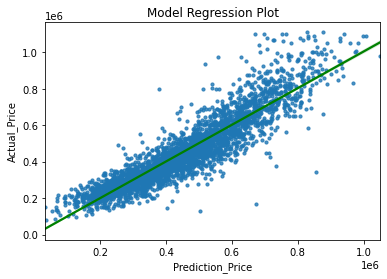

In [59]:
linear_model(X_train,y_train,X_test,y_test)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     924.2
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        01:10:06   Log-Likelihood:            -2.0812e+05
No. Observations:               16401   AIC:                         4.164e+05
Df Residuals:                   16313   BIC:                         4.171e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.483e+06   4.35e+06     -0.571      0.568    -1.1e+07    6.05e+06
bedrooms      -3197.6999   1047.444     -3.053      0.002   -5250.805   -1144.595
bathrooms      1.342e+04   1609.807      8.335      0.000    1.03e+04    1.66e+04
sqft_living      66.3704      3.298     20.126      0.000      59.907      72.834
sqft_lot          1.3856      0.410      3.380      0.001       0.582       2.189
floors        -1.445e+04   1952.007     -7.405      0.000   -1.83e+04   -1.06e+04
waterfront      2.71e+05   2.11e+04     12.866      0.000     2.3e+05    3.12e+05
view           3.437e+04   1215.597     28.275      0.000     3.2e+04    3.68e+04
condition      2.423e+04   1084.894     22.330      0.000    2.21e+04    2.64e+04
grade          4.184e+04   1150.036     36.379      0.000    3.96e+04    4.41e+04
sqft_above       57.9081      3.670     15.781      0.000      50.716      65.101
basement_yn    8830.6732   2424.252      3.643      0.000    4078.875    1.36e+04
yr_built       -523.8568     37.384    -14.013      0.000    -597.133    -450.580
renovated_yn   3.638e+04   3888.101      9.356      0.000    2.88e+04     4.4e+04
lat           -1.961e+04   3.98e+04     -0.492      0.623   -9.77e+04    5.85e+04
long          -3.327e+04    3.3e+04     -1.009      0.313   -9.79e+04    3.14e+04
sqft_living15    27.6707      2.050     13.501      0.000      23.653      31.688
sqft_lot15        0.0352      0.497      0.071      0.944      -0.939       1.009
month_sold    -2563.9970    197.105    -13.008      0.000   -2950.344   -2177.650
zipcode_98002  1.221e+04   7831.822      1.559      0.119   -3141.097    2.76e+04
zipcode_98003   -99.8721   7149.040     -0.014      0.989   -1.41e+04    1.39e+04
zipcode_98004  5.216e+05    1.5e+04     34.681      0.000    4.92e+05    5.51e+05
zipcode_98005  3.387e+05   1.54e+04     21.971      0.000    3.08e+05    3.69e+05
zipcode_98006  2.741e+05   1.28e+04     21.466      0.000    2.49e+05    2.99e+05
zipcode_98007  2.575e+05   1.56e+04     16.558      0.000    2.27e+05    2.88e+05
zipcode_98008  2.463e+05   1.51e+04     16.287      0.000    2.17e+05    2.76e+05
zipcode_98010  7.439e+04    1.6e+04      4.653      0.000    4.31e+04    1.06e+05
zipcode_98011  1.539e+05   1.96e+04      7.859      0.000    1.16e+05    1.92e+05
zipcode_98014  1.388e+05   2.87e+04      4.833      0.000    8.25e+04    1.95e+05
zipcode_98019  1.092e+05   2.18e+04      4.996      0.000    6.63e+04    1.52e+05
zipcode_98022  8735.9373   1.28e+04      0.681      0.496   -1.64e+04    3.39e+04
zipcode_98023 -1.908e+04   6949.723     -2.745      0.006   -3.27e+04   -5455.303
zipcode_98024  1.657e+05   2.44e+04      6.797      0.000    1.18e+05    2.13e+05
zipcode_98027  2.376e+05   1.39e+04     17.054      0.000     2.1e+05    2.65e+05
zipcode_98028  1.395e+05   1.91e+04      7.301   

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa2fac2fc40>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'QQ Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

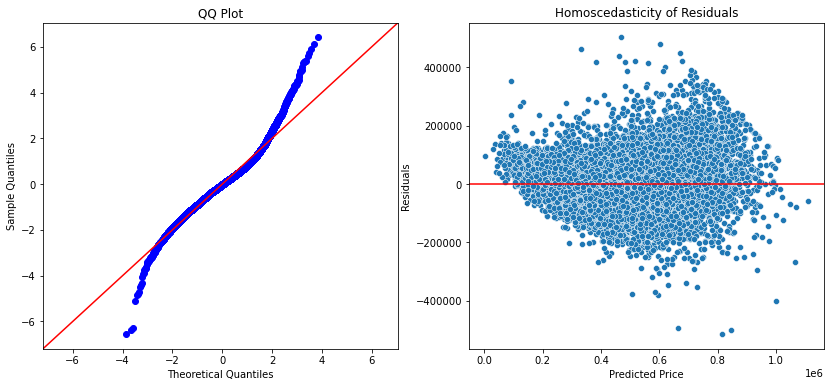

In [60]:
model_summary(df3)

The model has improved significantly - RMSE decreased and R squared values increased significantly with no a big difference between train and test sets. Homoscedasticity plot also looks slightly better for this model. Q-Q plot does not look as great as those from the previous iteratioins but it is not too bad either.

## Model 4
Since Model 3 with One Hot Encoding worked very well, I wanted to re-visit the selected features that were used in Model 2 and apply the selection for the next model.

In [61]:
df4 = df3.drop(['floors','waterfront','view','grade','lat','long','sqft_living15','sqft_lot15','month_sold'],
               axis =1)
df4

price  bedrooms  bathrooms  sqft_living  sqft_lot  condition  \
0     221,900.00000         3    1.00000         1180      5650          3   
1     538,000.00000         3    2.25000         2570      7242          3   
2     180,000.00000         2    1.00000          770     10000          3   
3     604,000.00000         4    3.00000         1960      5000          5   
4     510,000.00000         3    2.00000         1680      8080          3   
...             ...       ...        ...          ...       ...        ...   
21592 360,000.00000         3    2.50000         1530      1131          3   
21593 400,000.00000         4    2.50000         2310      5813          3   
21594 402,101.00000         2    0.75000         1020      1350          3   
21595 400,000.00000         3    2.50000         1600      2388          3   
21596 325,000.00000         2    0.75000         1020      1076          3   

       sqft_above  basement_yn  yr_built  renovated_yn  zipcode_98002  \
0            1180      0.00000      1955       0.00000        0.00000   
1            2170      1.00000      1951       1.00000        0.00000   
2             770      0.00000      1933       0.00000        0.00000   
3            1050      1.00000      1965       0.00000        0.00000   
4            1680      0.00000      1987       0.00000        0.00000   
...           ...          ...       ...           ...            ...   
21592        1530      0.00000      2009       0.00000        0.00000   
21593        2310      0.00000      2014       0.00000        0.00000   
21594        1020      0.00000      2009       0.00000        0.00000   
21595        1600      0.00000      2004       0.00000        0.00000   
21596        1020      0.00000      2008       0.00000        0.00000   

       zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        0.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0.00000   
21593        0.00000        0.00000        0.00000        0.00000   
21594        0.00000        0.00000        0.00000        0.00000   
21595        0.00000        0.00000        0.00000        0.00000   
21596        0.00000        0.00000        0.00000        0.00000   

       zipcode_98014  zipcode_98019  zipcode_98022  zipcode_98023  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
21592        0.00000        0.00000        0.00000        0

In [62]:
X = df4.drop('price', axis= 1)
y = df4['price']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 86779.57667434774
Test RMSE: 86934.82756743295
Train R2: 0.7924500498272671
Test R2: 0.7973747726655287


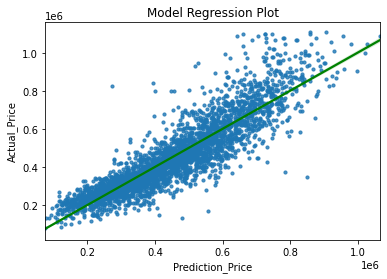

In [64]:
linear_model(X_train,y_train,X_test,y_test)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     805.4
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        01:10:07   Log-Likelihood:            -2.0976e+05
No. Observations:               16401   AIC:                         4.197e+05
Df Residuals:                   16322   BIC:                         4.203e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.678e+05   7.52e+04      3.563      0.000     1.2e+05    4.15e+05
bedrooms      -1.083e+04   1147.206     -9.439      0.000   -1.31e+04   -8579.504
bathrooms      1.607e+04   1729.961      9.289      0.000    1.27e+04    1.95e+04
sqft_living     101.2077      3.527     28.698      0.000      94.295     108.120
sqft_lot          3.6995      0.297     12.475      0.000       3.118       4.281
condition      2.294e+04   1193.609     19.217      0.000    2.06e+04    2.53e+04
sqft_above       76.3699      3.743     20.405      0.000      69.034      83.706
basement_yn    1.672e+04   2666.082      6.271      0.000    1.15e+04    2.19e+04
yr_built       -213.0766     37.310     -5.711      0.000    -286.209    -139.944
renovated_yn   4.176e+04   4270.629      9.779      0.000    3.34e+04    5.01e+04
zipcode_98002 -1691.0294   8399.019     -0.201      0.840   -1.82e+04    1.48e+04
zipcode_98003  1.522e+04   7756.226      1.962      0.050      12.261    3.04e+04
zipcode_98004  5.405e+05   9597.484     56.322      0.000    5.22e+05    5.59e+05
zipcode_98005  3.566e+05   1.04e+04     34.433      0.000    3.36e+05    3.77e+05
zipcode_98006  3.035e+05   7404.742     40.984      0.000    2.89e+05    3.18e+05
zipcode_98007  2.723e+05   9585.102     28.413      0.000    2.54e+05    2.91e+05
zipcode_98008  2.625e+05   7771.487     33.773      0.000    2.47e+05    2.78e+05
zipcode_98010  4.435e+04   1.49e+04      2.970      0.003    1.51e+04    7.36e+04
zipcode_98011  1.548e+05   8669.019     17.857      0.000    1.38e+05    1.72e+05
zipcode_98014  9.311e+04   1.93e+04      4.823      0.000    5.53e+04    1.31e+05
zipcode_98019  8.348e+04   9380.058      8.899      0.000    6.51e+04    1.02e+05
zipcode_98022  7056.0204   9109.817      0.775      0.439   -1.08e+04    2.49e+04
zipcode_98023 -3092.8962   6843.523     -0.452      0.651   -1.65e+04    1.03e+04
zipcode_98024  1.255e+05   2.02e+04      6.213      0.000    8.59e+04    1.65e+05
zipcode_98027  2.445e+05   8087.912     30.231      0.000    2.29e+05     2.6e+05
zipcode_98028  1.455e+05   7812.107     18.628      0.000     1.3e+05    1.61e+05
zipcode_98029  2.581e+05   7581.261     34.045      0.000    2.43e+05    2.73e+05
zipcode_98030  8370.1337   7821.979      1.070      0.285   -6961.800    2.37e+04
zipcode_98031  1.641e+04   7737.647      2.121      0.034    1245.152    3.16e+04
zipcode_98032  7514.0468   9983.471      0.753      0.452   -1.21e+04    2.71e+04
zipcode_98033   3.33e+05   7284.089     45.717      0.000    3.19e+05    3.47e+05
zipcode_98034  1.946e+05   6686.879     29.108      0.000    1.82e+05    2.08e+05
zipcode_98038  3.531e+04   6752.524      5.229      0.000    2.21e+04    4.85e+04
zipcode_98039  6.759e+05   3.93e+04     17.213      0.000    5.99e+05    7.53e+05
zipcode_98040  4.628e+05   9703.645     47.693   

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa2f9987100>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'QQ Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

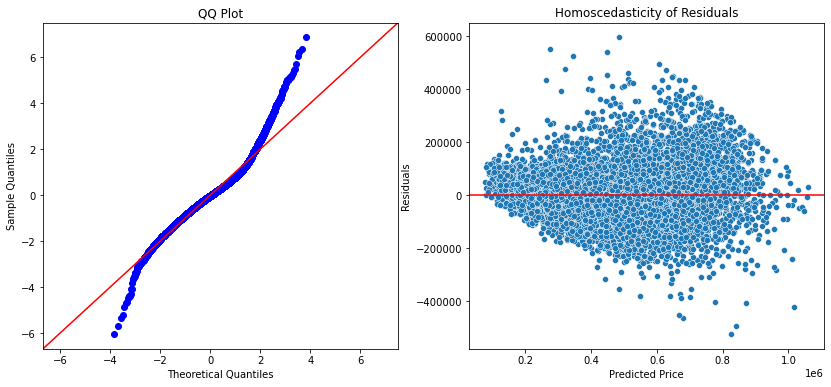

In [65]:
model_summary(df4)

Given that this model also uses selected features, it is a pretty strong model compared to the Model 2. However, Model 3 still shows the best result.

## Model 5
For our last model, we will use the log transormation on the continuous variables.

In [66]:
# Create a temporary table to select continuous variable which we will run log trasformation on.
temp = df3.copy()

In [67]:
temp.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement_yn',
       'yr_built', 'renovated_yn', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'month_sold', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipcod

In [68]:
# Select the continuous variables
con = ['sqft_living','sqft_lot','yr_built','sqft_living15','sqft_lot15']

df_con = temp[con]

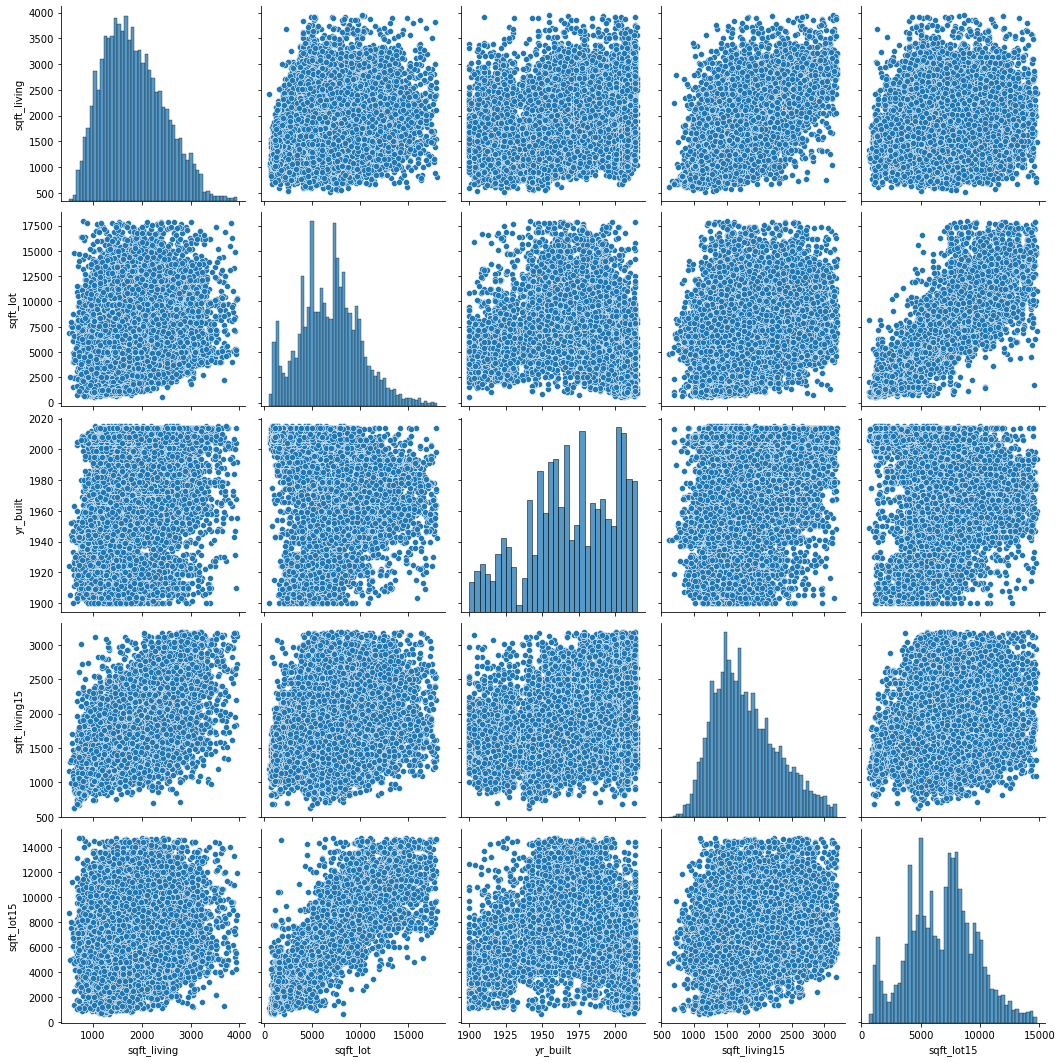

In [69]:
# Create a pairplot to check variable distributions
cont_pp = sns.pairplot(df_con, height = 3)

In [70]:
# Run the log transformation on the selected continuous variables
log_names = [f'{column}_log' for column in df_con.columns]

df_con_log = np.log(df_con)
df_con_log.columns = log_names

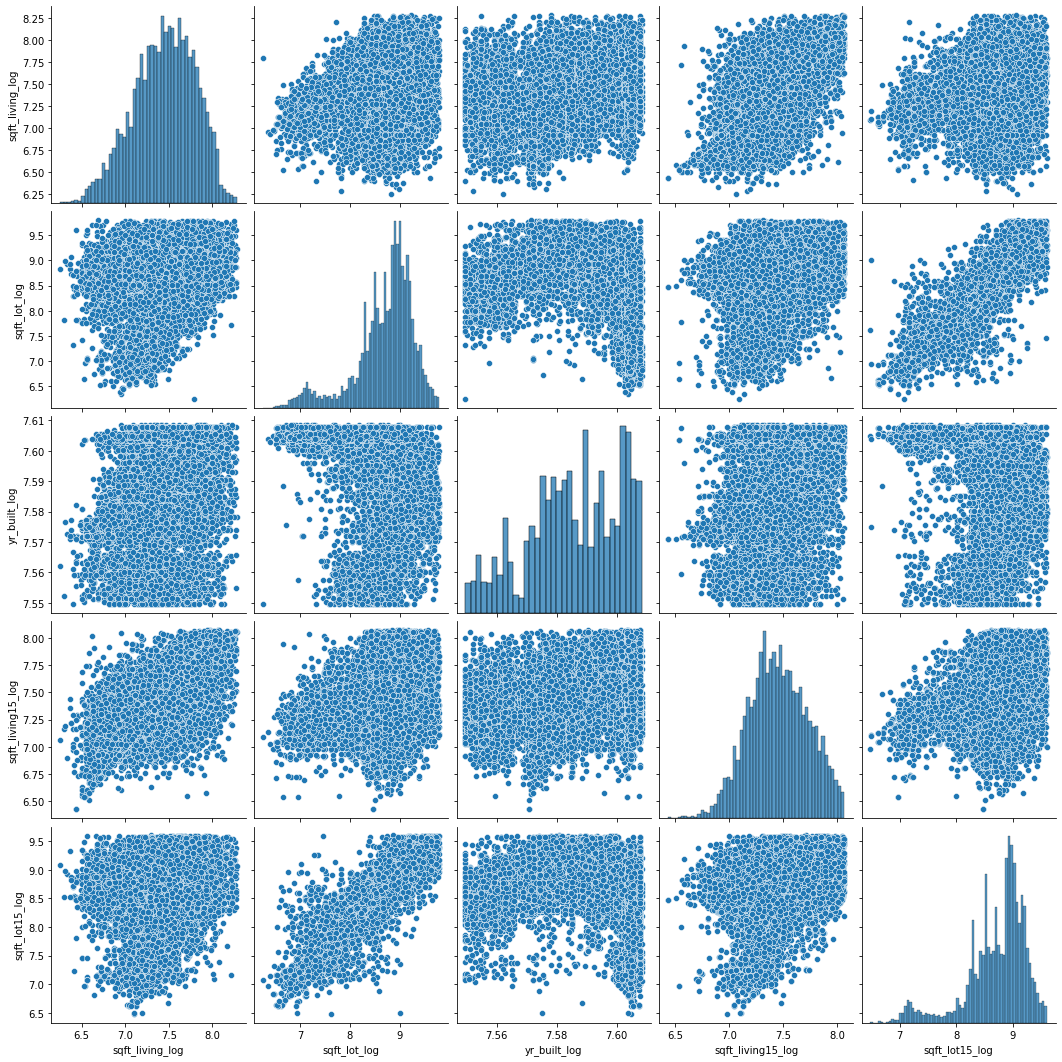

In [71]:
# Run another pairplot after the log transformation
cont_pp2 = sns.pairplot(df_con_log, height= 3)

In [72]:
# Add the log-transformed columns into a DataFrame
df6 = pd.concat([df_con_log, temp], axis= 1)
df6.head()

sqft_living_log  sqft_lot_log  yr_built_log  sqft_living15_log  \
0          7.07327       8.63941       7.57815            7.20042   
1          7.85166       8.88765       7.57610            7.43248   
2          6.64639       9.21034       7.56683            7.90839   
3          7.58070       8.51719       7.58325            7.21524   
4          7.42655       8.99715       7.59438            7.49554   

   sqft_lot15_log         price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0         8.63941 221,900.00000         3    1.00000         1180      5650   
1         8.94102 538,000.00000         3    2.25000         2570      7242   
2         8.99492 180,000.00000         2    1.00000          770     10000   
3         8.51719 604,000.00000         4    3.00000         1960      5000   
4         8.92306 510,000.00000         3    2.00000         1680      8080   

   floors  waterfront    view  condition  grade  sqft_above  basement_yn  \
0 1.00000     0.00000 0.00000          3      7        1180      0.00000   
1 2.00000     0.00000 0.00000          3      7        2170      1.00000   
2 1.00000     0.00000 0.00000          3      6         770      0.00000   
3 1.00000     0.00000 0.00000          5      7        1050      1.00000   
4 1.00000     0.00000 0.00000          3      8        1680      0.00000   

   yr_built  renovated_yn      lat       long  sqft_living15  sqft_lot15  \
0      1955       0.00000 47.51120 -122.25700           1340        5650   
1      1951       1.00000 47.72100 -122.31900           1690        7639   
2      1933       0.00000 47.73790 -122.23300           2720        8062   
3      1965       0.00000 47.52080 -122.39300           1360        5000   
4      1987       0.00000 47.61680 -122.04500           1800        7503   

   month_sold  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0          10        0.00000        0.00000        0.00000        0.00000   
1          12        0.00000        0.00000        0.00000        0.00000   
2           2        0.00000        0.00000        0.00000        0.00000   
3          12        0.00000        0.00000        0.00000        0.00000   
4           2        0.00000        0.00000        0.00000        0.00000   

   zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  \
0        0.00000        0.00000        0.00000        0.00000        0.00000   
1        0.00000        0.00000        0.00000        0.00000        0.00000   
2        0.00000        0.00000        0.00000        0.00000        0.00000   
3        0.00000        0.00000        0.00000        0.00000        0.00000   
4        0.00000        0.00000        0.00000        0.00000        0.00000   

   zipcode_98014  zipcode_98019  zipcode_98022  zipcode_98023  zipcode_98024  \
0        0.00000        0.00000        0.00000        0.00000        0.00000   
1        0.00000        0.00000        0.00000        0.00000        0.00000   
2        0.00000        0.00000        0.00000        0.00000        0.00000   
3        0.00000        0.00000        0.00000        0.00000        0.00000   
4        0.00000        0.00000        0.00000        0.00000        0.00000   

   zipcode_98027  zipcode_98028  zipcode_98029  zipcode_98030  zipcode_98031  \
0        0.00000        0.00000        0.00000        0.00000        0.00000   
1        0.00000        0.00000        0.00000        0.00000        0.00000   
2        0.00000        1.00000        0.00000        0.00000        0.00000   
3        0.00000        0.00000        0.00000        0.00000        0.00000   
4        0.00000        0.00000        0.00000        0.00000        0.00000   

   zipcode_98032  zipcode_98033  zipcode_98034  zipcode_98038  zipcode_98039  \
0        0.00000        0.00000        0.00000        0.00000        0.00000   
1        0.00000        0.00000        0.00000        0.00000        0.00000   
2        0.00000        0.00000        0.00000       

In [73]:
# Drop the original columns that we ran log transformation on
df6.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], inplace= True)

In [74]:
X = df6.drop('price', axis= 1)
y = df6['price']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     924.2
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        01:10:18   Log-Likelihood:            -2.0796e+05
No. Observations:               16401   AIC:                         4.161e+05
Df Residuals:                   16311   BIC:                         4.168e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.063e+05   4.36e+06     -0.093      0.926   -8.96e+06    8.15e+06
sqft_living_log    7.151e+04   5684.529     12.579      0.000    6.04e+04    8.26e+04
sqft_lot_log       3.541e+04   2737.670     12.934      0.000       3e+04    4.08e+04
yr_built_log      -6.157e+05   7.53e+04     -8.181      0.000   -7.63e+05   -4.68e+05
sqft_living15_log -1.372e+05   1.48e+04     -9.269      0.000   -1.66e+05   -1.08e+05
sqft_lot15_log     5.833e+04   4514.221     12.922      0.000    4.95e+04    6.72e+04
bedrooms          -3543.6082   1054.682     -3.360      0.001   -5610.900   -1476.316
bathrooms          1.663e+04   1608.866     10.333      0.000    1.35e+04    1.98e+04
floors             1183.7340   2094.150      0.565      0.572   -2921.029    5288.497
waterfront         2.819e+05   2.09e+04     13.510      0.000    2.41e+05    3.23e+05
view               3.499e+04   1203.816     29.063      0.000    3.26e+04    3.73e+04
condition          2.529e+04   1076.465     23.495      0.000    2.32e+04    2.74e+04
grade              4.347e+04   1145.109     37.962      0.000    4.12e+04    4.57e+04
sqft_above           65.5744      3.544     18.505      0.000      58.628      72.520
basement_yn        2.493e+04   2438.916     10.222      0.000    2.01e+04    2.97e+04
renovated_yn       3.856e+04   3852.942     10.008      0.000     3.1e+04    4.61e+04
lat               -5.007e+04   3.95e+04     -1.267      0.205   -1.28e+05    2.74e+04
long              -5.524e+04   3.27e+04     -1.690      0.091   -1.19e+05    8825.497
sqft_living15       102.5084      8.362     12.259      0.000      86.118     118.899
sqft_lot15          -12.0365      0.743    -16.205      0.000     -13.492     -10.581
month_sold        -2592.0626    195.244    -13.276      0.000   -2974.762   -2209.363
zipcode_98002      1.411e+04   7763.819      1.818      0.069   -1106.219    2.93e+04
zipcode_98003      1550.7781   7082.233      0.219      0.827   -1.23e+04    1.54e+04
zipcode_98004      5.472e+05   1.49e+04     36.611      0.000    5.18e+05    5.77e+05
zipcode_98005      3.671e+05   1.53e+04     23.953      0.000    3.37e+05    3.97e+05
zipcode_98006      2.944e+05   1.27e+04     23.200      0.000     2.7e+05    3.19e+05
zipcode_98007      2.783e+05   1.54e+04     18.038      0.000    2.48e+05    3.09e+05
zipcode_98008      2.685e+05    1.5e+04     17.890      0.000    2.39e+05    2.98e+05
zipcode_98010      8.441e+04   1.58e+04      5.329      0.000    5.34e+04    1.15e+05
zipcode_98011      1.734e+05   1.94e+04      8.925      0.000    1.35e+05    2.11e+05
zipcode_98014      1.621e+05   2.85e+04      5.691      0.000    1.06e+05    2.18e+05
zipcode_98019      1.329e+05   2.17e+04      6.132      0.000    9.04e+04    1.75e+05
zipcode_98022      1.258e+04   1.27e+04      0.989      0.323   -1.23e+04

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa2eb28cbb0>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'QQ Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

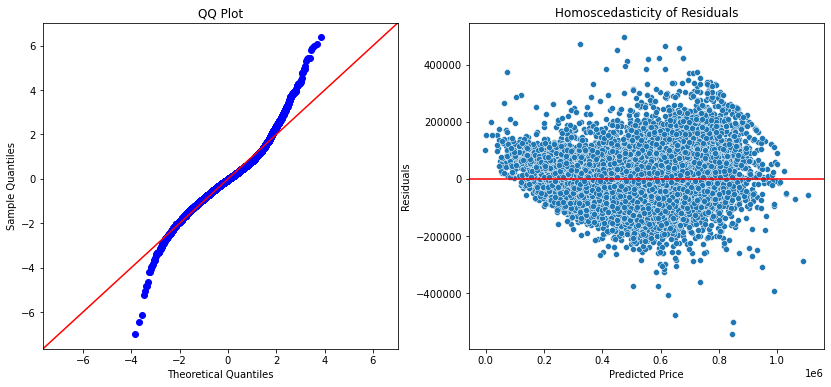

In [76]:
model_summary(df6)

Train RMSE: 77697.63015138273
Test RMSE: 78059.2264765415
Train R2: 0.833619232154376
Test R2: 0.8366367338654556


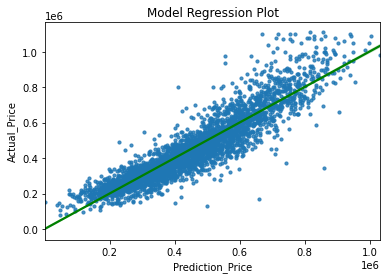

In [77]:
linear_model(X_train, y_train, X_test, y_test)

## Conclusion
Our winning model (Model 3) has an R squared value of 0.831, indicating that the model is capable of explaining 83.1% of the variability in a property's price.From this analysis, we can conclude that `waterfront`, `grade`, and `view` are features that have strong relationship with the target variable (`price`). Model 3 combined with EDA performed in the above led to below three recommendations.

**1. Secure waterfront properties when available.** While there are not that many, our analysis shows that a waterfront property can be worth $344,597 more than an inland property on average. There were only 146 waterfront properties to begin with in the data set, which consists of 0.80% of the total transactions. Given that acquiring a waterfront property is quite rare and a waterfront property can be worth a lot more, I recommend the team to prioritize acquiring waterfront properties to their listings. 

**2. Advertise and show the properties to many people.** It was very evident from our analysis that the housing price has a direct relationship with the number of viewings to potential buyers. I highly recommend advertising each property if possible, and creating a small "competition" will definitely help.

**3. Grading matters.** Higher grades yield higher housing prices. I recommend the team to avoid including low grade properties as the sales price increases with higher grade. This will provide the team with opportunities to close deals in their/seller's favor.